<a href="https://colab.research.google.com/github/eylulyaltir/DSA210-Project/blob/main/machinelearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

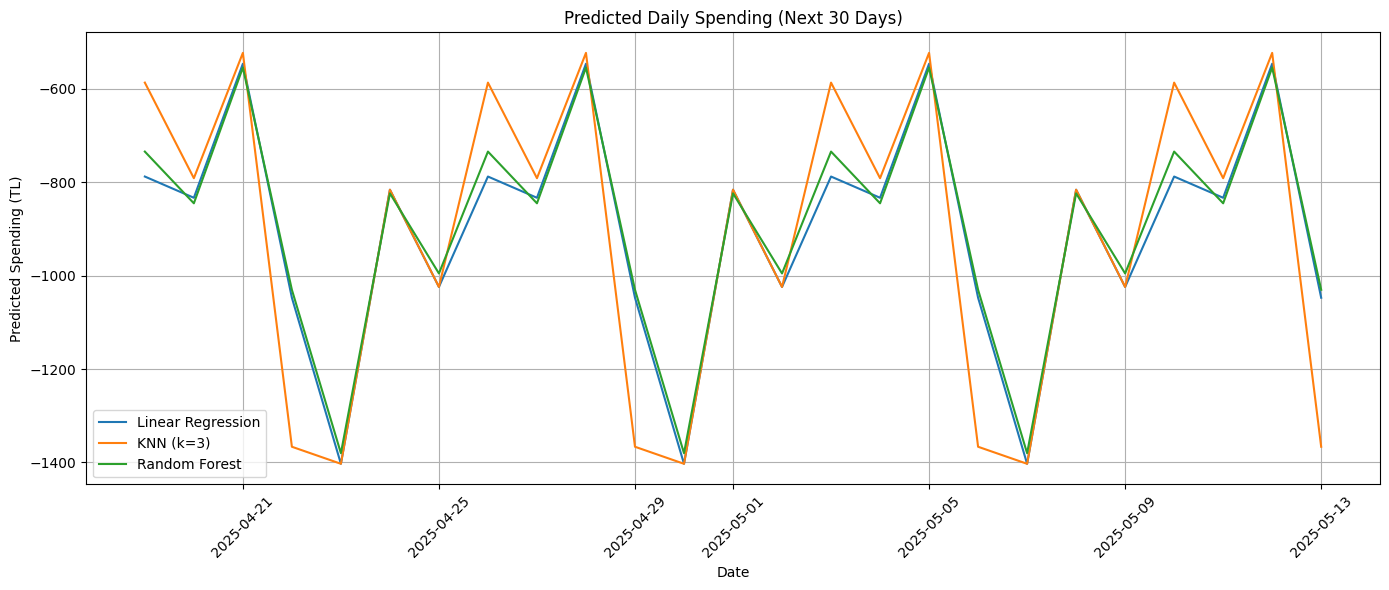

In [4]:
# Imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")


# STEP 1: Load and Clean Training Data

transactions_ml = pd.read_csv("Hesap HareketleriML.csv", sep=';')
weather_ml = pd.read_excel("weatherdataphase3.xlsx")

# Clean transaction data
transactions_ml['Date'] = pd.to_datetime(transactions_ml['Date'].str[:10], errors='coerce')
transactions_ml['Payment'] = (
    transactions_ml['Payment']
    .str.replace(' TL', '', regex=False)
    .str.replace(',', '.')
    .str.strip()
)
transactions_ml['Payment'] = pd.to_numeric(transactions_ml['Payment'], errors='coerce')

# Clean weather data and merge
weather_ml['Date'] = pd.to_datetime(weather_ml['datetime'], errors='coerce')
weather_ml = weather_ml[['Date', 'temp', 'humidity', 'feelslike', 'windspeed', 'conditions']]
merged_ml = pd.merge(transactions_ml, weather_ml, on='Date', how='inner')

# Enrich with weekday features
merged_ml['day_of_week'] = merged_ml['Date'].dt.day_name()
merged_ml['is_weekend'] = merged_ml['Date'].dt.weekday >= 5

# Aggregate daily spending
daily_ml = merged_ml.groupby(['Date', 'day_of_week', 'is_weekend'])['Payment'].sum().reset_index()
X_train = pd.get_dummies(daily_ml[['day_of_week', 'is_weekend']], drop_first=True)
y_train = daily_ml['Payment']


# STEP 2: Load and Enrich Forecast Data

forecast_df = pd.read_excel("retrievebulkdataset-2.xlsx")
forecast_df = forecast_df[['datetime', 'temp', 'humidity', 'feelslike', 'windspeed', 'conditions']].copy()
forecast_df.rename(columns={'datetime': 'Date'}, inplace=True)
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'], errors='coerce')
forecast_df['day_of_week'] = forecast_df['Date'].dt.day_name()
forecast_df['is_weekend'] = forecast_df['Date'].dt.weekday >= 5

# Create forecast features
X_forecast = pd.get_dummies(forecast_df[['day_of_week', 'is_weekend']], drop_first=True)
X_forecast = X_forecast.reindex(columns=X_train.columns, fill_value=0)

# STEP 3: Train Models and Predict

lr = LinearRegression().fit(X_train, y_train)
knn = KNeighborsRegressor(n_neighbors=3).fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

forecast_df['Pred_LR'] = lr.predict(X_forecast)
forecast_df['Pred_KNN'] = knn.predict(X_forecast)
forecast_df['Pred_RF'] = rf.predict(X_forecast)

# STEP 4: Plot Predictions

plt.figure(figsize=(14, 6))
sns.lineplot(data=forecast_df, x='Date', y='Pred_LR', label='Linear Regression')
sns.lineplot(data=forecast_df, x='Date', y='Pred_KNN', label='KNN (k=3)')
sns.lineplot(data=forecast_df, x='Date', y='Pred_RF', label='Random Forest')
plt.title('Predicted Daily Spending (Next 30 Days)')
plt.ylabel('Predicted Spending (TL)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
